In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import (
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    pipeline, DataCollatorForSeq2Seq, EarlyStoppingCallback
)
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from safetensors.torch import load_file

2025-08-24 17:19:56.916343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756055997.083085      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756055997.136293      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read the CSV file
data = pd.read_csv("/kaggle/input/eng-naga/raw_data (1).csv")
extra_data=pd.read_csv("/kaggle/input/eng-naga/Nagamese Khobor  Comic - Sheet1.csv")

In [3]:
data.shape

(7950, 2)

In [4]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [5]:
target_texts = list(data["English"])  
source_texts = list(data["Nagamese"]) 



# Split the data into training and validation sets
train_source_texts, val_source_texts, train_target_texts, val_target_texts = train_test_split(
    source_texts, target_texts, test_size=0.20, random_state=40
)


In [6]:
import random
random.seed(7)
# Combine and shuffle the training data
combined_train = list(zip(train_source_texts, train_target_texts))
random.shuffle(combined_train)

# Unzip back into separate lists
train_source_texts, train_target_texts = zip(*combined_train)
train_source_texts = list(train_source_texts)
train_target_texts = list(train_target_texts)

In [7]:
print(len(train_source_texts))
print(len(val_source_texts))

6360
1590


In [8]:
from datasets import Dataset

# Tokenize function
def tokenize_function(examples):
    model_inputs = tokenizer(examples["source_texts"], return_tensors="pt",max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(examples["target_texts"], return_tensors="pt",max_length=128, truncation=True, padding="max_length")["input_ids"]
    # labels = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels]
    model_inputs["labels"]=labels
    return model_inputs

# Convert lists to Hugging Face Dataset
train_dataset = Dataset.from_dict({"source_texts": train_source_texts, "target_texts": train_target_texts})
val_dataset = Dataset.from_dict({"source_texts": val_source_texts, "target_texts": val_target_texts})

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["source_texts", "target_texts"])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["source_texts", "target_texts"])



Map:   0%|          | 0/6360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

In [9]:
print(train_dataset.shape)
print(val_dataset.shape)

(6360, 3)
(1590, 3)


In [10]:
print(train_dataset["input_ids"][0])
print(train_dataset["input_ids"][1])

print(train_dataset["labels"][0])
print(train_dataset["labels"][1])

[250004, 6098, 70144, 66664, 11, 333, 300, 15503, 6327, 706, 5922, 63811, 3319, 161, 29053, 1172, 34, 46620, 14, 112935, 70144, 311, 24, 110162, 837, 4, 72205, 298, 837, 4, 204, 10752, 58457, 311, 13673, 21751, 5, 26, 1519, 41092, 86, 1013, 70144, 32129, 311, 79, 93, 837, 4, 48359, 40, 58863, 34, 196, 11, 37135, 15025, 19185, 40, 123, 6504, 466, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[250004, 2371, 4526, 33443, 34, 298, 3075, 4, 52, 647, 36164, 196, 11, 949, 333, 111788, 6327, 915, 6846, 72205, 24, 11395, 837, 974, 1172, 34, 6098, 290, 143, 70144, 752, 298, 3238, 6, 49249, 1926, 3075, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
!pip install sacrebleu
import sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.2 MB/s eta 0:00:00


In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode tokenized outputs into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU expects reference translations as a **list of lists**
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    ter = sacrebleu.corpus_ter(decoded_preds, [decoded_labels])
    chrf = sacrebleu.corpus_chrf(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score,"ter":ter.score,"chrf":chrf.score}

In [13]:
# Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    logging_strategy="epoch", 
    eval_strategy="epoch", 
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    seed = 40,
    save_total_limit=2,
    num_train_epochs=25,
    predict_with_generate=True,
    optim="adafactor", 
    report_to=[],
    fp16=True,
    logging_dir="./logs",
    overwrite_output_dir=True,
    load_best_model_at_end=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)],
    compute_metrics=compute_metrics,
)

# Start Training
trainer.train()


Epoch,Training Loss,Validation Loss,Bleu,Ter,Chrf
1,4.286000,0.414821,21.237090,73.294550,39.442363
2,0.363500,0.355421,26.867809,67.392020,45.802362
3,0.282400,0.347804,28.839251,66.288897,47.862259
4,0.202700,0.367498,28.348029,64.164974,47.345318


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1592, training_loss=1.283666792826437, metrics={'train_runtime': 3693.0136, 'train_samples_per_second': 43.054, 'train_steps_per_second': 2.694, 'total_flos': 6891472662036480.0, 'train_loss': 1.283666792826437, 'epoch': 4.0})

In [14]:
model.save_pretrained("./mbart_model")
tokenizer.save_pretrained("./mbart_model")

('./mbart_model/tokenizer_config.json',
 './mbart_model/special_tokens_map.json',
 './mbart_model/sentencepiece.bpe.model',
 './mbart_model/added_tokens.json',
 './mbart_model/tokenizer.json')

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

Using device: cuda


In [16]:
source_texts = val_source_texts
reference_texts = val_target_texts

In [17]:
# Translate source texts using the model
model.eval()
machine_translations = []
batch_size=32
for i in range(0, len(source_texts), batch_size):
    batch_texts = source_texts[i : i + batch_size]  # Slice batch
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    batch_translations = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    machine_translations.extend(batch_translations)

In [18]:

wrapped_reference_texts = [reference_texts] 
bleu = sacrebleu.corpus_bleu(machine_translations, wrapped_reference_texts)
print("BLEU Score:", bleu.score)
ter = sacrebleu.corpus_ter(machine_translations, wrapped_reference_texts)
print("TER Score:", ter.score)
chrf = sacrebleu.corpus_chrf(machine_translations, wrapped_reference_texts)
print("CHRF Score:", chrf.score)

BLEU Score: 28.77361011161401
TER Score: 66.33829098293178
CHRF Score: 47.83598956968305


MBartModel is using MBartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Input: Morom laga bhai khan, jodi Isor pora amikhan ke iman morom korise, titia hoile amikhan bi ekjon-ekjon ke morom koribole lage.
Translated: Beloved, if God has loved us, we should also love one another.
Reference: Beloved, if God so loved us, we also should love one another.


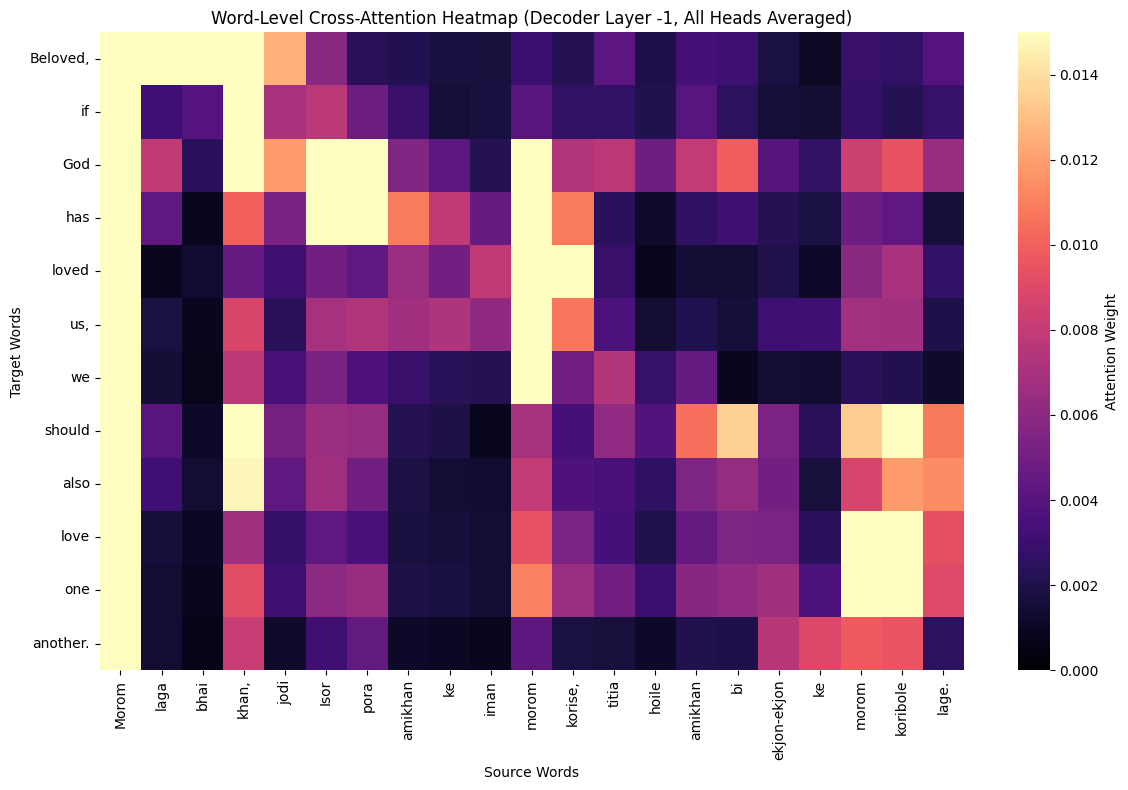


🔗 Word Alignments (English → Nagamese):

Nagamese Word   →  English Word
-----------------------------------
Beloved,        →  Morom
if              →  Morom
God             →  Morom
has             →  Morom
loved           →  Morom
us,             →  Morom
we              →  morom
should          →  Morom
also            →  Morom
love            →  Morom
one             →  Morom
another.        →  Morom


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def merge_sentencepiece_tokens(tokens):
    words = []
    current_word = ""
    mapping = []
    word_idx = -1

    for i, tok in enumerate(tokens):
        if tok.startswith("▁") or tok.startswith("_"):  # SentencePiece or underscore-prefix
            if current_word:
                words.append(current_word)
            current_word = tok[1:]  # remove prefix
            word_idx += 1
        else:
            current_word += tok
        mapping.append(word_idx)
    if current_word:
        words.append(current_word)
    return words, mapping

def aggregate_attention(attn_matrix, src_map, tgt_map):
    num_tgt_words = max(tgt_map) + 1
    num_src_words = max(src_map) + 1
    agg_matrix = np.zeros((num_tgt_words, num_src_words))
    count_matrix = np.zeros((num_tgt_words, num_src_words))

    for i_tgt, tgt_word_idx in enumerate(tgt_map):
        for i_src, src_word_idx in enumerate(src_map):
            agg_matrix[tgt_word_idx][src_word_idx] += attn_matrix[i_tgt][i_src]
            count_matrix[tgt_word_idx][src_word_idx] += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1
    return agg_matrix / count_matrix

# ----------------------------
# Your original pipeline
# ----------------------------
n = 28
inputs = tokenizer(source_texts[n], return_tensors="pt", max_length=128, truncation=True).to(device)

with torch.no_grad():
    generated = model.generate(**inputs, max_length=128)
    translated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

print(f"Input: {source_texts[n]}")
print(f"Translated: {translated_text}")
print(f"Reference: {reference_texts[n]}")

decoder_input_ids = generated[:, :-1]

with torch.no_grad():
    out = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=decoder_input_ids,
        output_attentions=True,
        return_dict=True
    )

cross_attn_all_heads = out.cross_attentions[-1][0]
cross_attn_avg = cross_attn_all_heads.mean(dim=0)  # shape: [tgt_len, src_len]

# ----------------------------
# Convert tokens to words + mapping
# ----------------------------
src_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True)
tgt_tokens = tokenizer.convert_ids_to_tokens(decoder_input_ids[0], skip_special_tokens=True)

src_words, src_map = merge_sentencepiece_tokens(src_tokens)
tgt_words, tgt_map = merge_sentencepiece_tokens(tgt_tokens)

# ----------------------------
# Aggregate attention
# ----------------------------
attn_np = cross_attn_avg[:len(tgt_tokens), :len(src_tokens)].cpu().numpy()
word_attn = aggregate_attention(attn_np, src_map, tgt_map)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(word_attn, 
            xticklabels=src_words, 
            yticklabels=tgt_words,
            cmap="magma", 
            vmin=0, vmax=0.015,
            cbar_kws={"label": "Attention Weight"})
plt.title("Word-Level Cross-Attention Heatmap (Decoder Layer -1, All Heads Averaged)")
plt.xlabel("Source Words")
plt.ylabel("Target Words")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ----------------------------
# Print Word-to-Word Alignments
# ----------------------------
print("\n🔗 Word Alignments (English → Nagamese):\n")
print(f"{'Nagamese Word':<15} →  English Word")
print("-" * 35)

for tgt_idx, tgt_word in enumerate(tgt_words):
    src_idx = np.argmax(word_attn[tgt_idx])
    print(f"{tgt_word:<15} →  {src_words[src_idx]}")

